# Importing libraries

In [ ]:
import xgboost as xgb
import talib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Starting data and visualizatioin

In [3]:
df = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
df.columns = df.columns.droplevel(1) 
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.440331,6.455077,6.391279,6.422877,493729600
2010-01-05,6.451465,6.487878,6.417459,6.458086,601904800
2010-01-06,6.348846,6.477045,6.342225,6.451465,552160000
2010-01-07,6.337109,6.379842,6.291066,6.372319,477131200
2010-01-08,6.379240,6.379842,6.291367,6.328682,447610800


Price,Close,High,Low,Open,Volume
count,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03
mean,57.574681,58.154507,56.940304,57.532586,2.422834e+08
std,55.520111,56.088908,54.889500,55.463714,2.204578e+08
min,5.779475,5.898345,5.725306,5.789105,2.404830e+07
25%,16.948884,17.103420,16.785686,16.966749,9.266760e+07
50%,29.039495,29.255415,28.786078,29.039399,1.526602e+08
75%,88.776266,90.046468,88.015227,88.781727,3.284715e+08
max,196.927673,198.428656,195.824309,196.838214,1.880998e+09


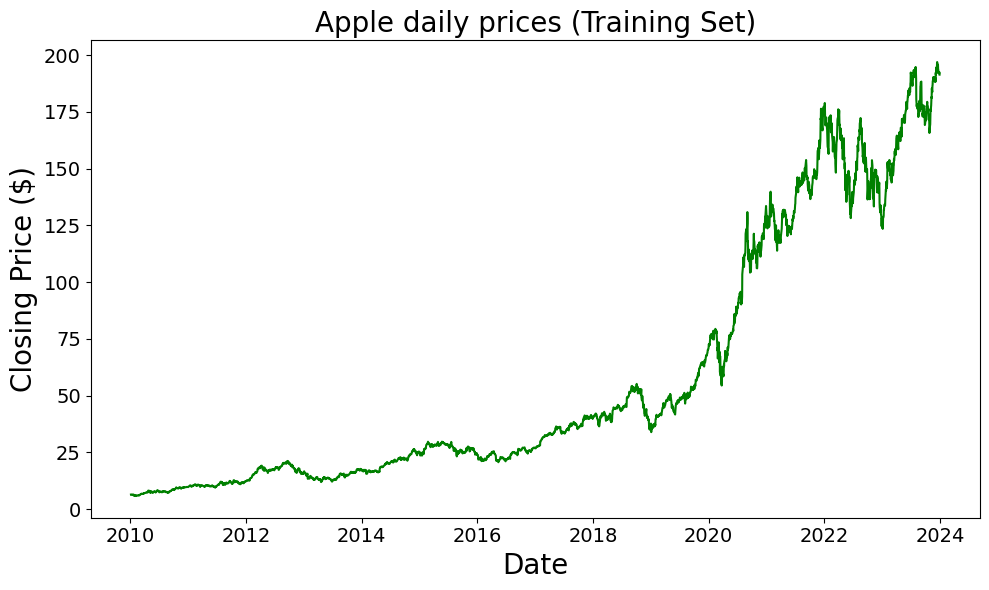

In [4]:
plt.figure(figsize=(10,6))
plt.plot(
  df.index,
  df['Close'],
  #label="Close Price ($)",
  color="green"
)
#plt.legend(fontsize=18, loc="upper left")
plt.yticks(fontsize=14)
plt.xlabel("Date", fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel("Closing Price ($)", fontsize=20)
plt.title("Apple daily prices (Training Set)", fontsize=20)
plt.tight_layout()
df.describe()

# Feature engineering
Since XGBoost is essentially an ensemble algorithm based on decision trees, feature normalization is not required. That being said, I will include a couple of technical indicators.

The XGBoost library can also be used for both regression and classification. In this example, I will use it for classification.

In [7]:
# Moving Averages (Momentum Indicator)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Relative Strength Index (Momentum Indicator)
df['RSI07'] = talib.RSI(df['Close'].values, timeperiod=7)
df['RSI14'] = talib.RSI(df['Close'].values, timeperiod=14)
df['RSI21'] = talib.RSI(df['Close'].values, timeperiod=21)

# Lagged Returns (Momentum-based Feature)
df['Return_1D'] = df['Close'].pct_change()  # Daily return
df['Return_5D'] = df['Close'].pct_change(periods=5)  # 5-day return
df['Return_10D'] = df['Close'].pct_change(periods=10)  # 10-day return

# Classification target (up/down)
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

df.dropna(inplace=True)
df.head()

Price,Close,High,Low,Open,Volume,MA10,MA50,MA200,RSI07,RSI14,RSI21,Return_1D,Return_5D,Return_10D,Target
Date,,,,,,,,,,,,,,,
2012-05-16,16.433514,16.758826,16.281842,16.673360,560896000,16.998700,17.748529,13.745336,22.175422,35.140601,41.375516,-0.012817,-0.040585,-0.068091,0
2012-05-17,15.953216,16.476242,15.953216,16.410337,717220000,16.843117,17.748186,13.766584,15.767465,30.446934,37.727651,-0.029227,-0.070813,-0.088859,1
2012-05-18,15.961040,16.353159,15.714273,16.068775,732292400,16.738180,17.741199,13.787320,16.227521,30.609527,37.821416,0.000490,-0.064107,-0.061690,1
2012-05-21,16.890934,16.898759,16.071485,16.085029,631106000,16.713503,17.750895,13.814993,52.329705,46.590336,47.657014,0.058260,0.005481,-0.014399,0
2012-05-22,16.761225,17.270106,16.629114,17.139800,694870400,16.679767,17.753886,13.842581,48.900234,45.032412,46.577902,-0.007679,0.006869,-0.019730,1


/tmp/ipykernel_932/1860697180.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=18)


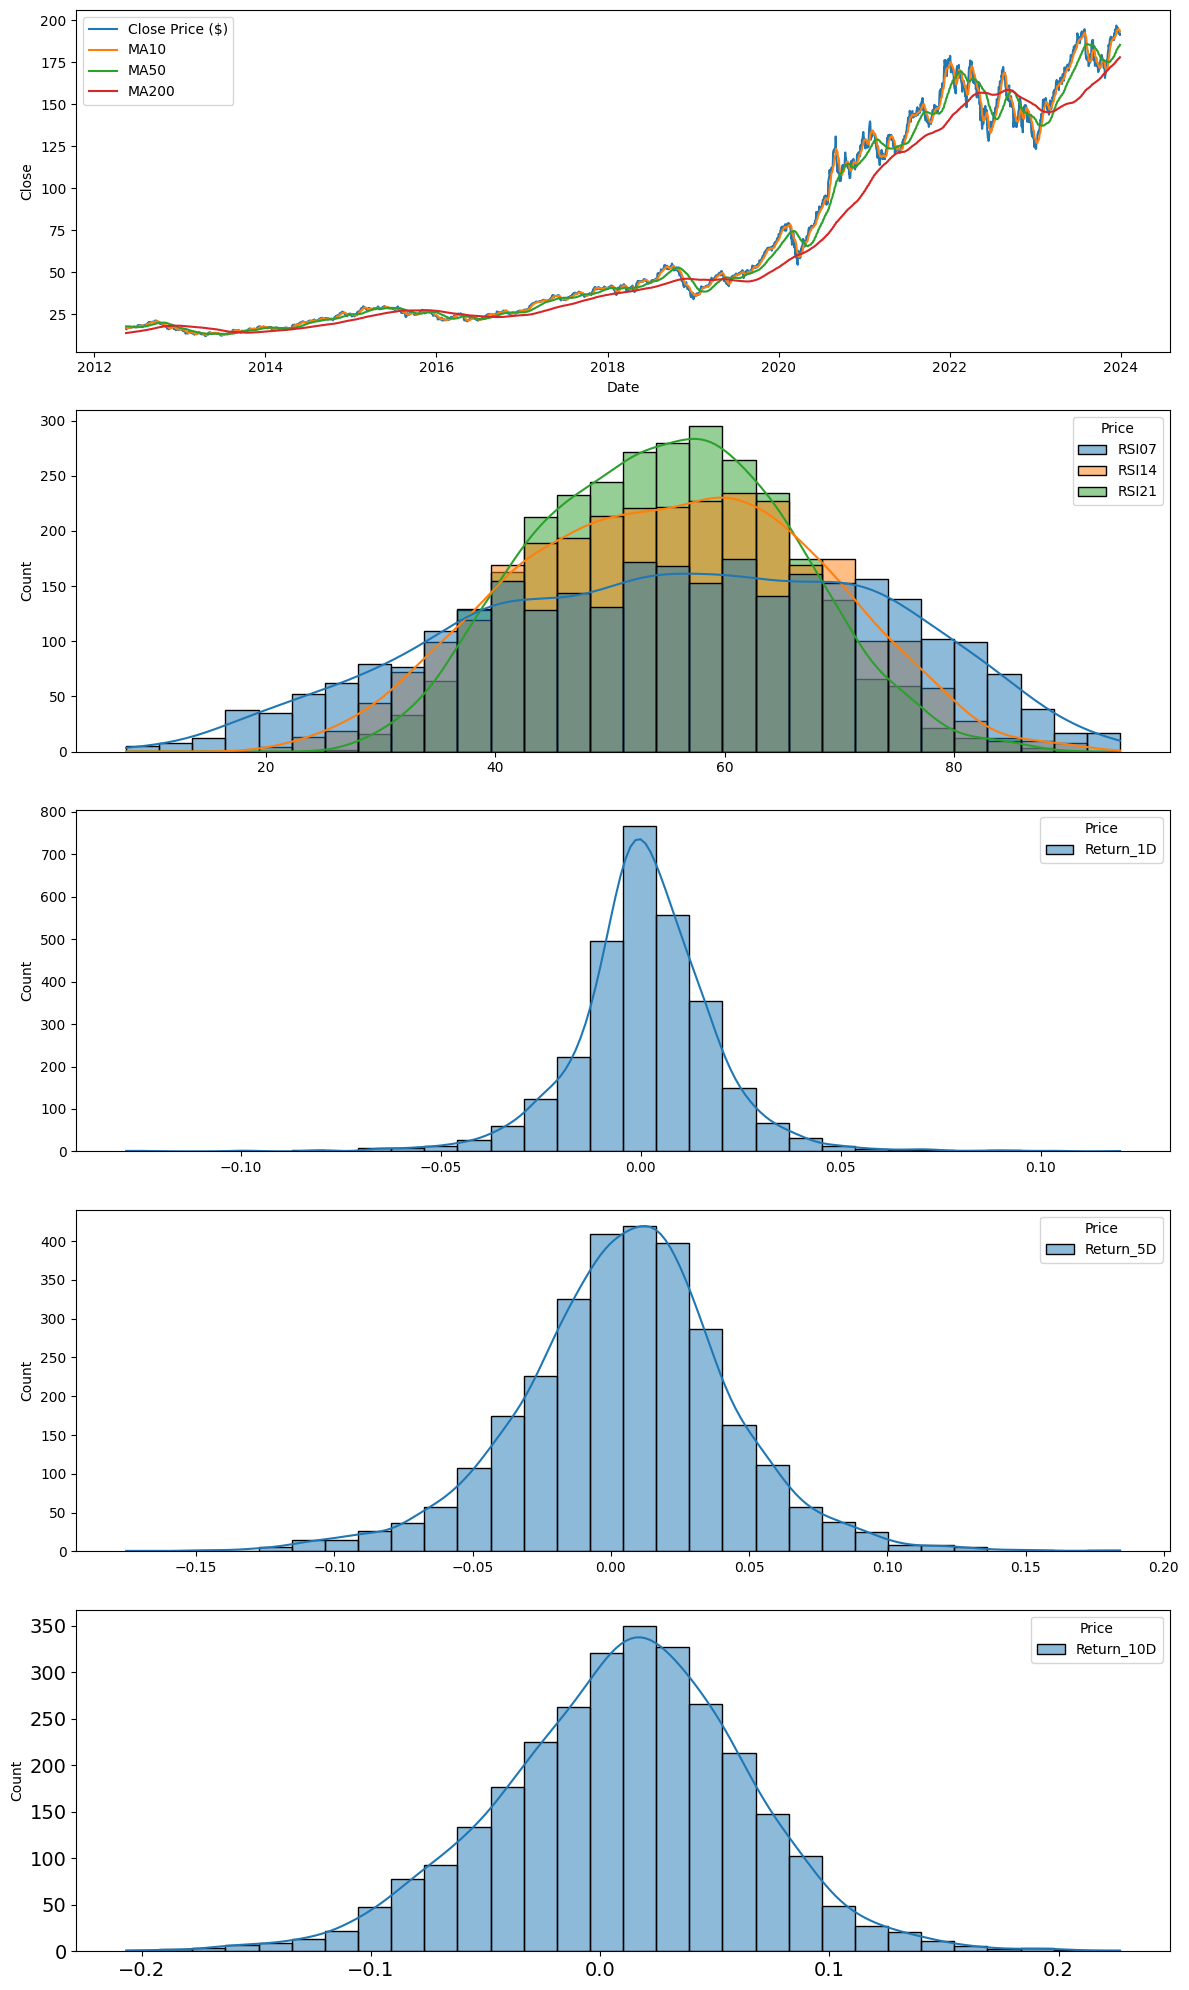

In [8]:
#fig, ax = plt.subplots(3,2,figsize=(12, 8), gridspec_kw={'height_ratios': [4, 2,1], 'width_ratios': [2, 1]})
fig, ax = plt.subplots(5,1,figsize=(12, 20))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
sns.lineplot(x=df.index, y=df['Close'], label='Close Price ($)', ax=ax[0])
sns.lineplot(x=df.index, y=df['MA10'], label='MA10', ax=ax[0])
sns.lineplot(x=df.index, y=df['MA50'], label='MA50', ax=ax[0])
sns.lineplot(x=df.index, y=df['MA200'], label='MA200', ax=ax[0])

#fig.delaxes(ax[0,1])

sns.histplot(df[['RSI07', 'RSI14', 'RSI21']], bins=30, kde=True, ax=ax[1])
sns.histplot(df[['Return_1D']], bins=30, kde=True, ax=ax[2])
sns.histplot(df[['Return_5D']], bins=30, kde=True, ax=ax[3])
sns.histplot(df[['Return_10D']], bins=30, kde=True, ax=ax[4])


plt.tight_layout()

Interestingly enough, the longer the period of the RSI, the closer it is to a normal distribution. RSI and N-day returns all correspond to a positively skewed bell curve, originating from the fact that Apple stocks have been extremely lucrative over the years. Another small takeaway is that holdoing for 1 day only is most likely harmful, though that should be common sense, since we aren't even taking into account transactional costs, which move around 0.25%

In [9]:
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'MA10', 'MA50', 'MA200',
       'RSI14', 'RSI07', 'RSI21', 'Return_1D', 'Return_5D', 'Return_10D']
X = df[features]
y = df['Target']

# X = pd.DataFrame(scale(X), index=X.index, columns=X.columns) # Scaling features just to be safe
y.value_counts()
X.describe()

Price,Close,High,Low,Open,Volume,MA10,MA50,MA200,RSI14,RSI07,RSI21,Return_1D,Return_5D,Return_10D
count,2925.000000,2925.000000,2925.000000,2925.000000,2.925000e+03,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000
mean,67.197888,67.875635,66.456829,67.146481,1.791000e+08,66.927899,65.753095,61.519793,55.166589,55.487836,54.882133,0.000996,0.004878,0.009778
std,56.244141,56.821013,55.602597,56.186456,1.488090e+08,56.029105,55.096747,52.010978,13.009578,17.815494,10.771486,0.017898,0.037955,0.053909
min,11.925924,12.202902,11.760103,11.847747,2.404830e+07,12.420666,13.189400,13.745336,21.030097,7.772005,27.375035,-0.128647,-0.175307,-0.206865
25%,23.635290,23.897784,23.333901,23.621839,8.605600e+07,23.341125,23.180808,23.360770,45.408088,41.826502,46.859898,-0.007533,-0.016909,-0.023389
50%,40.364105,40.766537,40.019250,40.418744,1.275316e+08,40.374012,40.168243,37.972282,55.409991,56.173115,54.848451,0.000886,0.006381,0.012322
75%,123.160507,124.437780,121.967788,123.046311,2.147656e+08,123.017907,123.657356,105.429010,64.691728,69.736579,62.631511,0.010314,0.027414,0.045351
max,196.927673,198.428656,195.824309,196.838214,1.460852e+09,194.788515,185.832604,178.058898,90.694991,94.512601,86.573172,0.119808,0.184141,0.226803


# Train/Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # Shuffle=False since stocks are time series data

# XGBoost uses DMatrix instead of numpy arrays
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

# Fitting model

[0]	Test-logloss:0.69344
[100]	Test-logloss:0.72474
[124]	Test-logloss:0.72874
Accuracy: 0.5231
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       281
           1       0.56      0.37      0.45       304

    accuracy                           0.52       585
   macro avg       0.53      0.53      0.51       585
weighted avg       0.53      0.52      0.51       585

Strategy cumulative returns: 1.383165152757198
Buy-hold cumulative returns: 1.2692091915676302


count    584.000000
mean       1.171087
std        0.195178
min        0.887864
25%        0.991967
50%        1.102661
75%        1.379923
max        1.500879
Name: Return_1D, dtype: float64

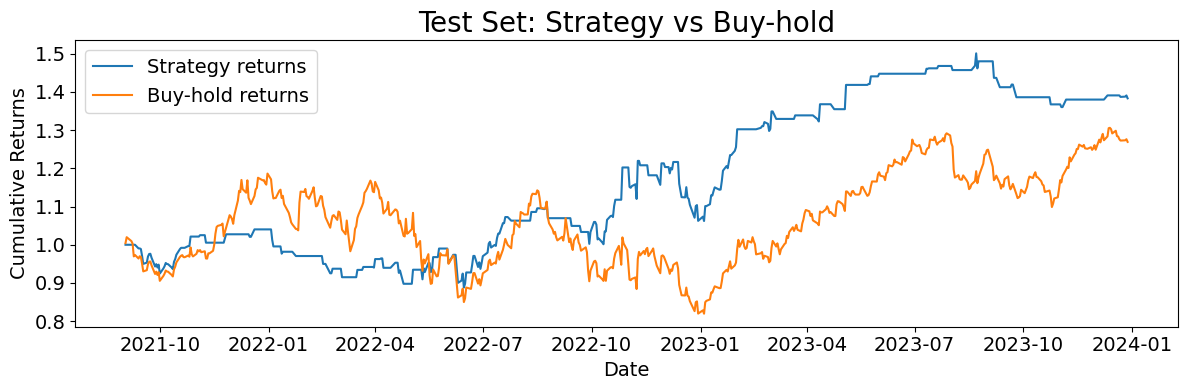

In [13]:
params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "logloss",
    "learning_rate": 0.1,
    "max_depth": 6,
}
model = xgb.train(params, train_data, num_boost_round=1000, evals=[(test_data, "Test")], early_stopping_rounds=100, verbose_eval=100)

# Make predictions
y_test_pred = model.predict(test_data)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Convert probabilities to 0 or 1

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred))

strategy_cumulative_returns = (1 + X_test['Return_1D'].shift(-1) * y_test_pred).cumprod()
buy_hold_cumulative_returns = (1 + X_test['Return_1D'].shift(-1)).cumprod()

fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(x=X_test.index, y=strategy_cumulative_returns, label='Strategy returns', ax=ax)
sns.lineplot(x=X_test.index, y=buy_hold_cumulative_returns, label='Buy-hold returns', ax=ax)
plt.title('Test Set: Strategy vs Buy-hold', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()

print(f"Strategy cumulative returns: {strategy_cumulative_returns.iloc[-2]}")
print(f"Buy-hold cumulative returns: {buy_hold_cumulative_returns.iloc[-2]}")
strategy_cumulative_returns.describe()


Sadly this model is also just slightly better than random guessing

/tmp/ipykernel_932/2551462347.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


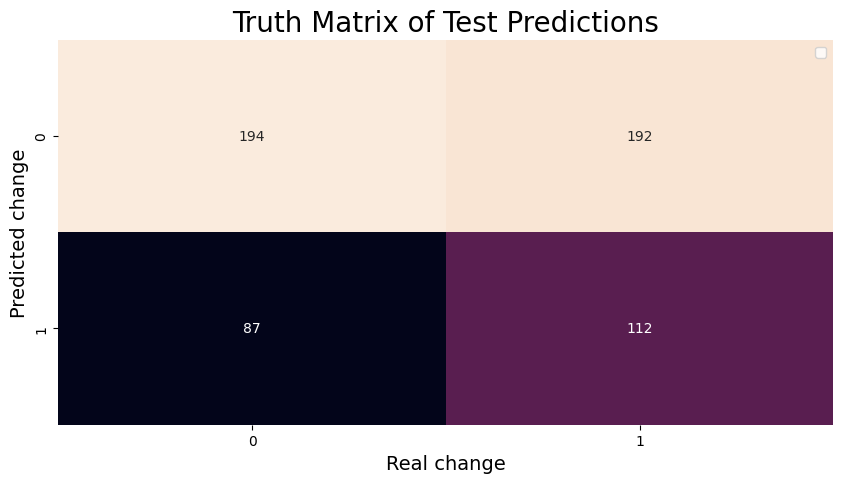

Efficacy of model relative to buy-hold: 108.98%
Accuracy: 52.31%


In [25]:
plt.figure(figsize=(10,5))
cm = confusion_matrix(y_test_pred, y_test.values)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Real change', fontsize=14)
plt.ylabel('Predicted change', fontsize=14)
plt.title("Truth Matrix of Test Predictions", fontsize=20)

plt.legend()
plt.show()
print(f"Efficacy of model relative to buy-hold: {(strategy_cumulative_returns.iloc[-2] / buy_hold_cumulative_returns.iloc[-2]) *100:.2f}%")
print(f"Accuracy: {(y_test_pred == y_test.values).sum() / len(y_test_pred) * 100:.2f}%")



# Conclusion
Overall accuracy of ~52.3%, and a model which outperforms Buy-hold over a period of 3 years. This was achieved after some time tuning parameters, which was not shown here. The results are much more promising than the attempts at using SVM or Linear Regression, showcasing the power of using ensemble models and trees for stock predicction. The fact that this result could be achieved with relatively little code also shows why XGBoost is the industrial standard for gradient boosting libraries.